In [1]:
# Importing dependencies
import pandas as pd
import numpy as np
from collections import defaultdict

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# For Hypothesis testing
import statsmodels.formula.api as smf

# For principal components analysis
from sklearn.decomposition import PCA

### Loading the Dataset

In [2]:
# Loading the dataset into pandas dataframe
path = "../data/census-income.data.gz"
# set the column names
censusColnames = ['Age', 'ClassOfWorker', 'Industry', 'Occupation', 'Education',
                  'WagePerHr', 'EducationalInst', 'MaritalStatus', 'IndustryCode', 
                  'OccupationCode', 'Race', 'HispanicOrigin', 'Sex', 'MemLabourUnion',
                  'UnemploymentReason', 'EmploymentStatus', 'CapitalGain', 'CapitalLoss',
                  'Dividends', 'FEDERALTAX', 'TaxFilerStat', 'PrevState', 
                  'HouseholdStatus', 'HouseholdSummary', 'INSTANCEWEIGHT', 
                  'MigrationCode_MSA', 'MigrationCode_REG', 
                  'MigrationCode_WITHIN_REG', 'HouseOneYearAgo', 
                  'MigrationPrevResInSunbelt', 'NumOfPersonForEmployer', 'Parent', 
                  'BirthCountryFather', 'BirthCountryMother', 'BirthCountrySelf', 
                  'Citizenship', 'OwnBusiness', 'VeteranQA', 'VeteranBenefits', 
                  'WeeksWorked', 'Year', 'targetIncome']
censusDf = pd.read_csv(path, sep=r',', skipinitialspace=True, 
                       names = censusColnames, header='infer')

# Printing the dimensions of the dataset
print(censusDf.shape[0],"rows,", censusDf.shape[1],"columns")

# Displaying first five elements of all columns
with pd.option_context('display.max_columns', None):
    display(censusDf.head())

199523 rows, 42 columns


,Age,ClassOfWorker,Industry,Occupation,Education,WagePerHr,EducationalInst,MaritalStatus,IndustryCode,OccupationCode,Race,HispanicOrigin,Sex,MemLabourUnion,UnemploymentReason,EmploymentStatus,CapitalGain,CapitalLoss,Dividends,FEDERALTAX,TaxFilerStat,PrevState,HouseholdStatus,HouseholdSummary,INSTANCEWEIGHT,MigrationCode_MSA,MigrationCode_REG,MigrationCode_WITHIN_REG,HouseOneYearAgo,MigrationPrevResInSunbelt,NumOfPersonForEmployer,Parent,BirthCountryFather,BirthCountryMother,BirthCountrySelf,Citizenship,OwnBusiness,VeteranQA,VeteranBenefits,WeeksWorked,Year,targetIncome
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


---

## Problem Statement

>From the various features in the census data set our aim is to build a predictive model to determine whether the income level for the people in United States exceeds the bracket of $50,000.

## Hypothesis Statement

From our problem statement is clear that it is a binary classification problem.

Let us generate some hypotheses which will help us in building the models more efficiently. We need to figure out some hypotheses which might influence our final outcome, hence we need to answer a simple question.

**Is There a Relationship Between the Response and Predictors?**

To test this we use the test between the Null Hypothesis $H_0$ versus the Alternate Hypothesis $H_a$.
* $H_0$ : There is no relationship between the response Income and the predictors.
    
* $H_a$ : There is some realtionship between the response and the predictors.

After building the model and fitting the data into our model, if the accuracy of the model beats the baseline and is statistically significant we will reject our Null Hypothesis $H_0$.


## Baseline

In order to evaluate our model we should define some baseline. Let us generate some statistics about our response variable so that we can set our baseline.

In [4]:
# Getting the count
incomeCount = censusDf['targetIncome'].value_counts()
print(incomeCount)

# Getting the proportion of data having -50000 as response
print(float(incomeCount[0]/len(censusDf['targetIncome']))*100,
     "% people have income below $50000.")

0    187141
1     12382
Name: targetIncome, dtype: int64
93.79419916500854 % people have income below $50000.


Most of the values are 0 in the responce variable, Income. Which means that the dataset is heavily skewed towards having income less than \$50,000. Which means that if we predict only below \$50,000, still our model accuracy would be **93.79%**.

---

## Data Wrangling

### 1. Missing Value Imputation

In [5]:
censusDf.isnull().sum().sort_values(ascending=False).head()

HispanicOrigin    874
targetIncome        0
Race                0
Dividends           0
CapitalLoss         0
dtype: int64

* We can observe from the above statistics that, there are no missing values in numerical columns of the dataset. 
* There is only one column in which there are 874 missing values, which is 'HispanicOrigin'.
* From the first five lines of dataframe displayed above we saw that there are some garbage/missing values in the dataframe labelled as '?', lets try to track them.

In [6]:
# There are lot of '?' appearing in the dataset lets track them
for i in censusDf.columns:
    if '?' in list(censusDf[i]):
        print(censusDf.loc[censusDf[i].isin(['?'])][i].value_counts())

?    708
Name: PrevState, dtype: int64
?    99696
Name: MigrationCode_MSA, dtype: int64
?    99696
Name: MigrationCode_REG, dtype: int64
?    99696
Name: MigrationCode_WITHIN_REG, dtype: int64
?    99696
Name: MigrationPrevResInSunbelt, dtype: int64
?    6713
Name: BirthCountryFather, dtype: int64
?    6119
Name: BirthCountryMother, dtype: int64
?    3393
Name: BirthCountrySelf, dtype: int64


The above missing values does not makes much sense if we substitute them, as they are nominal values. Let us label all the above missing values as 'Unavailable'. Also there are four columns in which there almost 50% of the values which are '?', it is better to drop those columns, as high proportion of missing values can be misleading.

In [7]:
# Dropping the columns with missing values more than 50% and storing in a new dataframe
censusDf_cleaned = censusDf.drop(['MigrationCode_MSA', 'MigrationCode_REG', 
                                  'MigrationCode_WITHIN_REG', 
                                  'MigrationPrevResInSunbelt'], axis=1)

# Replacing the '?' with the label 'Unavailable'
censusDf_cleaned = censusDf_cleaned.replace('?', 'Unavailable')

In [8]:
# Check if the values are replaced
for i in censusDf_cleaned.columns:
    if 'Unavailable' in list(censusDf_cleaned[i]):
        print(censusDf_cleaned.loc[censusDf_cleaned[i].isin(['Unavailable'])][i].value_counts())

Unavailable    708
Name: PrevState, dtype: int64
Unavailable    6713
Name: BirthCountryFather, dtype: int64
Unavailable    6119
Name: BirthCountryMother, dtype: int64
Unavailable    3393
Name: BirthCountrySelf, dtype: int64


* As we saw earlier, for the caolumn 'HispanicOrigin' we have few (874) missing values; lets see how the values are distributed in the column, so that we can impute the missing values.

In [9]:
censusDf_cleaned['HispanicOrigin'].value_counts().sort_values(ascending=False)

All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
Do not know                     306
Chicano                         304
Name: HispanicOrigin, dtype: int64

Creating a new column for the missing values for HispanicOrigin.

In [10]:
# store the missing value in a variable
missing_val = censusDf_cleaned[censusDf_cleaned.isnull()]['HispanicOrigin'].iloc[1]
# impute the missing values
censusDf_cleaned['HispanicOrigin'] = censusDf_cleaned['HispanicOrigin'].replace(
    missing_val, 'None')

In [11]:
# Check if the values are replaced
censusDf_cleaned['HispanicOrigin'].value_counts()

All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
None                            874
Do not know                     306
Chicano                         304
Name: HispanicOrigin, dtype: int64

##### **Check for missing values one last time.**

In [12]:
# Check for missing values
censusDf_cleaned.isnull().sum().sort_values(ascending=False).head()

targetIncome          0
OccupationCode        0
CapitalGain           0
EmploymentStatus      0
UnemploymentReason    0
dtype: int64

> Now there are no missing values in the dataset.

### 2. Feature Engineering

In [13]:
# Categorizing the columns

# Replacing the 'targetIncome' values with dummy variables
# - 50000. as the baseline. 0 for - 50000. and 1 for 50000+.
censusDf_cleaned['targetIncome'] = pd.get_dummies(
    censusDf_cleaned.targetIncome).iloc[:,1:]

# Features and Outcome
X = censusDf_cleaned.drop('targetIncome',1)
y = censusDf_cleaned.targetIncome
print("X (predictors) is ",X.shape[0],"rows,", X.shape[1],"columns, and..."\
      "\ny (response) is ",y.shape[0],"rows.")


X (predictors) is  199523 rows, 37 columns, and...
y (response) is  199523 rows.


##### **Let us check the categorical variables in for each feature, and decide which one to  use in our model.**

In [14]:
# Print out number of unique categorical values in each column
print("NUMBER OF UNIQUE VALUES IN EACH FEATURE:\n")
for col_name in X.columns:
    if X[col_name].dtype == 'object':
        unique_val = len(X[col_name].unique())
        print("'{col_name}' has --> {unique_val}\
        ".format(col_name=col_name, unique_val=unique_val))

NUMBER OF UNIQUE VALUES IN EACH FEATURE:

'ClassOfWorker' has --> 9        
'Education' has --> 17        
'EducationalInst' has --> 3        
'MaritalStatus' has --> 7        
'IndustryCode' has --> 24        
'OccupationCode' has --> 15        
'Race' has --> 5        
'HispanicOrigin' has --> 10        
'Sex' has --> 2        
'MemLabourUnion' has --> 3        
'UnemploymentReason' has --> 6        
'EmploymentStatus' has --> 8        
'FEDERALTAX' has --> 6        
'TaxFilerStat' has --> 6        
'PrevState' has --> 51        
'HouseholdStatus' has --> 38        
'HouseholdSummary' has --> 8        
'HouseOneYearAgo' has --> 3        
'Parent' has --> 5        
'BirthCountryFather' has --> 43        
'BirthCountryMother' has --> 43        
'BirthCountrySelf' has --> 43        
'Citizenship' has --> 5        
'VeteranQA' has --> 3        


##### It looks like the columns 'BirthCountryFather', 'BirthCountryMother' and 'BirthCountrySelf' have same number of unique values. Let us keep only one column, and drop the other two.

In [15]:
# Dropping the columns
X = X.drop(['BirthCountryFather', 'BirthCountryMother'], axis=1)
# keeping 'BirthCountrySelf' and renaming
X.rename(columns={'BirthCountrySelf': 'BirthCountry'}, inplace=True)

In [16]:
# Although, 'BirthCountry' has a lot of unique categories, ...
# ...most categories only have a few observations if compared to max (United-States)
X['BirthCountry'].value_counts().sort_values(ascending=False).head(10)

United-States         176989
Mexico                  5767
Unavailable             3393
Puerto-Rico             1400
Germany                  851
Philippines              845
Cuba                     837
Canada                   700
Dominican-Republic       690
El-Salvador              689
Name: BirthCountry, dtype: int64

In [17]:
# In this case, bucket low frequecy categories as "Other"
X['BirthCountry'] = ['United-States' if x == 'United-States' 
                       else 'Other-Countries' for x in X['BirthCountry']]
# check the values
X['BirthCountry'].value_counts().sort_values(ascending=False)

United-States      176989
Other-Countries     22534
Name: BirthCountry, dtype: int64

##### The column 'HouseholdStatus' has 38 unique values; only few of the categories have significant number of observations.

In [18]:
# Check the value counts
X['HouseholdStatus'].value_counts().sort_values(ascending=False).head(10)

Householder                                        53248
Child <18 never marr not in subfamily              50326
Spouse of householder                              41695
Nonfamily householder                              22213
Child 18+ never marr Not in a subfamily            12030
Secondary individual                                6122
Other Rel 18+ ever marr not in subfamily            1956
Grandchild <18 never marr child of subfamily RP     1868
Other Rel 18+ never marr not in subfamily           1728
Grandchild <18 never marr not in subfamily          1066
Name: HouseholdStatus, dtype: int64

It is better to categorize the values as other, which does not have significant count.

In [19]:
# Bucket the low frequency category as other
X['HouseholdStatus'] = ['Householder' if x == 'Householder'
                        else 'Children' if x == 'Child <18 never marr not in subfamily'
                        else 'Spouse' if x == 'Spouse of householder'
                        else 'Nonfamily' if x == 'Nonfamily householder'
                        else 'Child_18_plus' if x == 'Child 18+ never marr Not in a subfamily'
                        else 'Secondary_indv' if x == 'Secondary individual'
                       else 'Other_Householders' for x in X['HouseholdStatus']]
# check the values
X['HouseholdStatus'].value_counts().sort_values(ascending=False)

Householder           53248
Children              50326
Spouse                41695
Nonfamily             22213
Other_Householders    13889
Child_18_plus         12030
Secondary_indv         6122
Name: HouseholdStatus, dtype: int64

##### Lets check the 'PrevState' column, there are 51, unique values for the feature, lets see what are they.

In [20]:
# Check the value counts
X['PrevState'].value_counts().sort_values(ascending=False).head(10)

Not in universe    183750
California           1714
Utah                 1063
Florida               849
North Carolina        812
Unavailable           708
Abroad                671
Oklahoma              626
Minnesota             576
Indiana               533
Name: PrevState, dtype: int64

With approximately 200,000 rows in our dataset, there are almost 184,000 values for the 'PrevState' column, that say 'Not in universe', which is almost 96% of the entire row, since the survey has been conducted in the United States of America, all of them must belong to a state, hence the value stating "Not in universe" are the missing values. Having this much small information about the sate doesn't seem to be helpful, it is better that we drop this feature from our predictors variables list.

In [21]:
# Dropping the 'PrevState' column
X = X.drop(['PrevState'], axis=1)

#### Creating Dummies

**Coverting categorical variable in to _Dummy Variables_.** If we want to include a categorical feature in our machine learning model, one common solution is to create dummy variables. We drop the original feature from the dataset and add a dummied version of the feature to the dataset, which is easier for the model to interpret.

In [22]:
# Creating a list of categorical features to create a dummy variable of
# columns names in asscending order, according to number of diff unique values
features_to_dummy = ['Sex', 'BirthCountry', 'Year', 'EducationalInst', 
                     'MemLabourUnion', 'HouseOneYearAgo', 'OwnBusiness', 'VeteranQA',
                     'VeteranBenefits', 'Race', 'Parent', 'Citizenship', 
                     'UnemploymentReason', 'FEDERALTAX', 'TaxFilerStat', 
                     'MaritalStatus', 'HouseholdStatus', 'NumOfPersonForEmployer', 
                     'EmploymentStatus', 'HouseholdSummary', 'ClassOfWorker', 
                     'HispanicOrigin', 'OccupationCode', 'Education', 
                     'IndustryCode', 'Occupation', 'Industry','WeeksWorked']

Define a function to create dummy variables of the dataframe from the list of columns.

In [23]:
# Function to create the dummy categorical variables used for modeling
def create_dummies(df, col_name_list):
    """
    This function takes the dataframe and features list as input, 
    and returns the modified dataframe with dummy variables of the 
    features in the list col_name_list.
    
    :param df: target dataframe 
    :param col_name_list: list of the column names from the dataset
    :return: modifies the dataframe df inplace and returns dummied dataframe
             of features in col_name_list
    """
    for x in col_name_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

Calling the function create_dummies to convert our features in to dummy variables.

In [24]:
# Before dummies
print("Dataframe X has", X.shape[1],"columns",X.shape[0],"and rows.")

# Call the function create_dummies on X and replace the features with dummies
print("Creating dummies ...")
X = create_dummies(X, features_to_dummy)

# Printing the dimensions of the modified feature set
print("*** Now our dataframe has", X.shape[1],"columns",X.shape[0],"and rows. ***")

# display first five rows of all the features
with pd.option_context('display.max_columns', None):
    display(X.head())

Dataframe X has 34 columns 199523 and rows.
Creating dummies ...
*** Now our dataframe has 327 columns 199523 and rows. ***


,Age,WagePerHr,CapitalGain,CapitalLoss,Dividends,INSTANCEWEIGHT,Sex_Female,Sex_Male,BirthCountry_Other-Countries,BirthCountry_United-States,Year_94,Year_95,EducationalInst_College or university,EducationalInst_High school,EducationalInst_Not in universe,MemLabourUnion_No,MemLabourUnion_Not in universe,MemLabourUnion_Yes,HouseOneYearAgo_No,HouseOneYearAgo_Not in universe under 1 year old,HouseOneYearAgo_Yes,OwnBusiness_0,OwnBusiness_1,OwnBusiness_2,VeteranQA_No,VeteranQA_Not in universe,VeteranQA_Yes,VeteranBenefits_0,VeteranBenefits_1,VeteranBenefits_2,Race_Amer Indian Aleut or Eskimo,Race_Asian or Pacific Islander,Race_Black,Race_Other,Race_White,Parent_Both parents present,Parent_Father only present,Parent_Mother only present,Parent_Neither parent present,Parent_Not in universe,Citizenship_Foreign born- Not a citizen of U S,Citizenship_Foreign born- U S citizen by naturalization,Citizenship_Native- Born abroad of American Parent(s),Citizenship_Native- Born in Puerto Rico or U S Outlying,Citizenship_Native- Born in the United States,UnemploymentReason_Job leaver,UnemploymentReason_Job loser - on layoff,UnemploymentReason_New entrant,UnemploymentReason_Not in universe,UnemploymentReason_Other job loser,UnemploymentReason_Re-entrant,FEDERALTAX_Head of household,FEDERALTAX_Joint both 65+,FEDERALTAX_Joint both under 65,FEDERALTAX_Joint one under 65 & one 65+,FEDERALTAX_Nonfiler,FEDERALTAX_Single,TaxFilerStat_Abroad,TaxFilerStat_Midwest,TaxFilerStat_Northeast,TaxFilerStat_Not in universe,TaxFilerStat_South,TaxFilerStat_West,MaritalStatus_Divorced,MaritalStatus_Married-A F spouse present,MaritalStatus_Married-civilian spouse present,MaritalStatus_Married-spouse absent,MaritalStatus_Never married,MaritalStatus_Separated,MaritalStatus_Widowed,HouseholdStatus_Child_18_plus,HouseholdStatus_Children,HouseholdStatus_Householder,HouseholdStatus_Nonfamily,HouseholdStatus_Other_Householders,HouseholdStatus_Secondary_indv,HouseholdStatus_Spouse,NumOfPersonForEmployer_0,NumOfPersonForEmployer_1,NumOfPersonForEmployer_2,NumOfPersonForEmployer_3,NumOfPersonForEmployer_4,NumOfPersonForEmployer_5,NumOfPersonForEmployer_6,EmploymentStatus_Children or Armed Forces,EmploymentStatus_Full-time schedules,EmploymentStatus_Not in labor force,EmploymentStatus_PT for econ reasons usually FT,EmploymentStatus_PT for econ reasons usually PT,EmploymentStatus_PT for non-econ reasons usually FT,EmploymentStatus_Unemployed full-time,EmploymentStatus_Unemployed part- time,HouseholdSummary_Child 18 or older,HouseholdSummary_Child under 18 ever married,HouseholdSummary_Child under 18 never married,HouseholdSummary_Group Quarters- Secondary individual,HouseholdSummary_Householder,HouseholdSummary_Nonrelative of householder,HouseholdSummary_Other relative of householder,HouseholdSummary_Spouse of householder,ClassOfWorker_Federal government,ClassOfWorker_Local government,ClassOfWorker_Never worked,ClassOfWorker_Not in universe,ClassOfWorker_Private,ClassOfWorker_Self-employed-incorporated,ClassOfWorker_Self-employed-not incorporated,ClassOfWorker_State government,ClassOfWorker_Without pay,HispanicOrigin_All other,HispanicOrigin_Central or South American,HispanicOrigin_Chicano,HispanicOrigin_Cuban,HispanicOrigin_Do not know,HispanicOrigin_Mexican (Mexicano),HispanicOrigin_Mexican-American,HispanicOrigin_None,HispanicOrigin_Other Spanish,HispanicOrigin_Puerto Rican,OccupationCode_Adm support including clerical,OccupationCode_Armed Forces,OccupationCode_Executive admin and managerial,OccupationCode_Farming forestry and fishing,OccupationCode_Handlers equip cleaners etc,OccupationCode_Machine operators assmblrs & inspctrs,OccupationCode_Not in universe,OccupationCode_Other service,OccupationCode_Precision production craft & repair,OccupationCode_Private household services,OccupationCode_Professional specialty,OccupationCode_Protective services,OccupationCode_Sales,OccupationCode_Technicians and related support,OccupationCode_Transportation and material moving,Education_10

#### Principal Components Analysis

Principal component analysis (PCA) transforms the dataset of many features into few Principal Components that "summarize" the variance underying in the data. It is the  most common way of dimensionality reduction, and it works well where the features are highly corelated. The drawback of using PCA is that it makes it difficult to interpret the data.

In [25]:
# We will use PCA from sklearn.decomposition to find the principal components
pca = PCA(n_components=10) # 10 principal components
X_pca = pd.DataFrame(pca.fit_transform(X))

In [26]:
# Displaying the first few rows of 10 pcs
X_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-446.982542,-168.035772,-40.381395,-64.759638,-13.501660,-39.122762,2.385361,1.256710,0.119360,0.841583
1,-447.349032,-167.870671,-686.914257,-62.029238,-12.985453,-24.142538,-0.927172,-1.016997,-1.472031,-0.230199
2,-447.394376,-167.897641,-748.512380,-61.951289,-13.070459,15.885651,0.728191,1.405954,0.400895,1.034139
3,-446.967120,-168.122950,17.670191,-65.306601,-13.773969,24.926329,1.616421,-0.938406,0.308592,0.181718
4,-447.353242,-167.928242,-671.302999,-62.323231,-13.166087,23.967267,1.601772,-0.929753,0.280611,0.209144


_In this case we will not proceed with the principal components. Because it is not recommended to perform PCA on categorical data._

***

### Model Building

In [27]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [28]:
class ModelMetrics(object):

    # Random permutation cross-validator with 80-20 train test split
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state=1)
    # dictionary to store scores
    model_scores = dict()
    # default scoring metrics
    default_metric = ['accuracy','precision', 'recall']
    
    def __init__(self, model_name, model_obj, features, response):
        self.model_name = model_name
        self.model_obj = model_obj
        ModelMetrics.model_scores[model_name] = []
        self.cv = ModelMetrics.cv
        self.features = features
        self.response = response
        self.model_scores = ModelMetrics.model_scores
        
    def model_scoring(self, scoring_metric=default_metric):
        for metric in scoring_metric:
            n_fold_score = cross_val_score(self.model_obj,self.features,
                                                           self.response,
                                                           cv=self.cv,
                                                           scoring=metric)
            self.model_scores[self.model_name].append({metric:n_fold_score})
        model_scores = self.model_scores
        return model_scores

In [29]:
def create_metric_df(metric_dict):
    """takes input as dict obtained from ModelMetrics
    class and maps the scores to a pandas dataframe
    :params: 
    metric_dict : dictionary of scores 
    :returns:
    score_df : pandas dataframe mapping the metrics and model
    """
    
    # use for loop to store the values
    model_name, acc_nfolds, pre_nfolds, rec_nfolds = (list() for i in range(4)) 
    for model, metrics in metric_dict.items():
        model_name.append(model)
        acc_nfolds.append(list(metrics[0].values())[0])
        pre_nfolds.append(list(metrics[1].values())[0]) 
        rec_nfolds.append(list(metrics[2].values())[0])
    
    metric_col_names = ['accuracy', 'precision', 'recall',
                'accuracy_nfolds', 'precision_nfolds', 'recall_nfolds']
    score_df = pd.DataFrame(columns = metric_col_names, index=model_name)

    # assign values
    score_df['accuracy_nfolds'] = acc_nfolds
    score_df['precision_nfolds'] = pre_nfolds
    score_df['recall_nfolds'] = rec_nfolds
    score_df['accuracy'] = score_df['accuracy_nfolds'].apply(np.mean)
    score_df['precision'] = score_df['precision_nfolds'].apply(np.mean)
    score_df['recall'] = score_df['recall_nfolds'].apply(np.mean)
    
    return score_df

#### Generate plots

In [30]:
def plot_metric_each_fold(metric, title):
    metric = metric+"_nfolds"
    legend_list = list()
    for i,model in enumerate(list(final_results.index)):
        x_val = list("Fold-"+str(i) 
                     for i in range(len(final_results[metric][0])))
        y_val = final_results[metric][i]
        
        # fig size
        plt.rcParams["figure.figsize"] = (16, 9)
        plt.rcParams.update({'font.size': 15})
        plt.plot(x_val,y_val,
                marker=".", markeredgewidth=1,linestyle=":", linewidth=3.5)
        for a,b in zip(x_val,y_val): 
            plt.text(a, b, str(b))
        legend_list.append(model)
        plt.legend(legend_list)
        plt.title(title)

    # add a horiontal line for baseline
    if(metric == "accuracy_nfolds"):
        baseline = float(y.value_counts()[0]/len(y))
        plt.axhline(y=baseline, color='r', linestyle='-')

#### Logistic Regression Model

In [33]:
# Classifier implementing Logistic Regression
clf_log_reg = LogisticRegression()
# Creating object for metrics
log_reg_metrics_obj = ModelMetrics("Logistic Regression", clf_log_reg, X, y)
# get the metrics
log_reg_metrics = log_reg_metrics_obj.model_scoring()

#### Decision Tree

In [36]:
# Classifier implementing the Decision Tree
clf_d_tree = DecisionTreeClassifier()
# Creating object for metrics
clf_d_tree_metrics_obj = ModelMetrics("Decision Tree", clf_d_tree, X, y)
# get the metrics
clf_d_tree_metrics = clf_d_tree_metrics_obj.model_scoring()

#### Random Forest Classifier

In [39]:
# Classifier implementing  Random Forest Classifier
clf_RF = RandomForestClassifier()
# Creating object for metrics
clf_RF_metrics_obj = ModelMetrics("Random Forest Classifier", clf_RF, X, y)
# get the metrics
clf_RF_metrics = clf_RF_metrics_obj.model_scoring()

#### KNN

In [42]:
# Classifier implementing the k-nearest neighbors
clf_knn = KNeighborsClassifier()
# Creating object for metrics
clf_knn_metrics_obj = ModelMetrics("k-nearest neighbors", clf_knn, X, y)
# get the metrics
clf_knn_metrics = clf_knn_metrics_obj.model_scoring()

#### Store the results in a DataFrame object

In [44]:
# sotore the results in a data frame
final_results = create_metric_df(ModelMetrics.model_scores)
# print the average score for all folds
final_results.iloc[:,0:3]

,accuracy,precision,recall
Logistic Regression,0.952846,0.722250,0.384549
Decision Tree,0.933662,0.464265,0.474473
Random Forest Classifier,0.951816,0.721606,0.354212
k-nearest neighbors,0.941012,0.550060,0.247369


In [45]:
# scores for n folds
pd.set_option('display.max_colwidth', -1)
final_results.iloc[:,3:]

,accuracy_nfolds,precision_nfolds,recall_nfolds
Logistic Regression,"[0.95336424007, 0.952161383285, 0.954166144593, 0.952011026187, 0.951635133442, 0.953339180554, 0.953564716201, 0.95336424007, 0.952211502318, 0.952637514096]","[0.690789473684, 0.727685325265, 0.70987654321, 0.72451558551, 0.708823529412, 0.711913357401, 0.727901614143, 0.744237918216, 0.725634725635, 0.751117734724]","[0.396558959295, 0.383114297093, 0.387694900969, 0.351307189542, 0.385908726982, 0.402613311556, 0.387162714636, 0.397537728356, 0.360455655004, 0.393135725429]"
Decision Tree,"[0.935546923944, 0.932314246335, 0.9337927578, 0.932915674727, 0.932665079564, 0.933091091342, 0.934644781356, 0.934594662323, 0.933968174414, 0.933091091342]","[0.465202982601, 0.460415065334, 0.447121273989, 0.457991402892, 0.46734059098, 0.455043002346, 0.469825840421, 0.477307692308, 0.461906661348, 0.480499219969]","[0.466219051616, 0.481481481481, 0.461441213654, 0.479166666667, 0.472778222578, 0.466312780727, 0.475061324612, 0.490468625894, 0.475589910496, 0.476209048362]"
Random Forest Classifier,"[0.953414359103, 0.950557574239, 0.952637514096, 0.95075805037, 0.951284300213, 0.951810550056, 0.953013406841, 0.951534895377, 0.951585014409, 0.951559954893]","[0.702542372881, 0.717927631579, 0.731473408893, 0.711775043937, 0.724434035909, 0.685007974482, 0.748226950355, 0.73189009159, 0.726495726496, 0.736290322581]","[0.359211078473, 0.361210673039, 0.353560893384, 0.337418300654, 0.35228182546, 0.35688035933, 0.35241210139, 0.355043685465, 0.348657445077, 0.365444617785]"
k-nearest neighbors,"[0.942363112392, 0.940132815437, 0.942388171908, 0.941335672222, 0.940608946247, 0.940809422378, 0.941335672222, 0.94121037464, 0.940408470117, 0.939531387044]","[0.536499560246, 0.552859618718, 0.533759124088, 0.550046772685, 0.558394160584, 0.540768509841, 0.546093064091, 0.578324225865, 0.535650623886, 0.56820234869]","[0.255979857323, 0.254082039028, 0.246523388116, 0.240196078431, 0.244995996797, 0.235606369947, 0.254292722813, 0.252184273233, 0.244507729862, 0.245319812793]"


### Generate Plots

Plot the average accuracy for all the folds for all models.

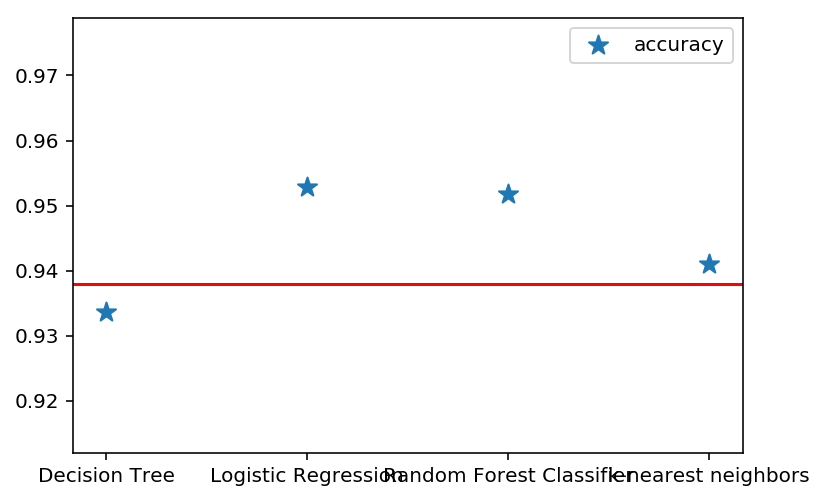

In [46]:
# create a scatter plot of accuracy for all the models
plt.scatter(final_results.index, final_results["accuracy"], 
            100,alpha=1, marker='*')
plt.axhline(y=float(y.value_counts()[0]/len(y)), 
            color='r', linestyle='-') # horizintal basline
plt.legend()

### The confusion matrix.
Class 0 = Income is less than 50k.<br/>
Class 1 = Income is More than 50k.<br/>
![title](../data/conf-mat.png)

> **Plotting all the scoring metrics for all the classifiers for each fold.**

### Accuracy

Accuracy is the metric for the % of correct prediction. It is defined as the given formula below. It is simply a ratio of correctly predicted observation to the total observations.<br/>

$Accuracy = \dfrac{Total Number of correct classifications}{Total Number of Cases} = \dfrac{TP + TN}{TP + TN + FP + FN}$

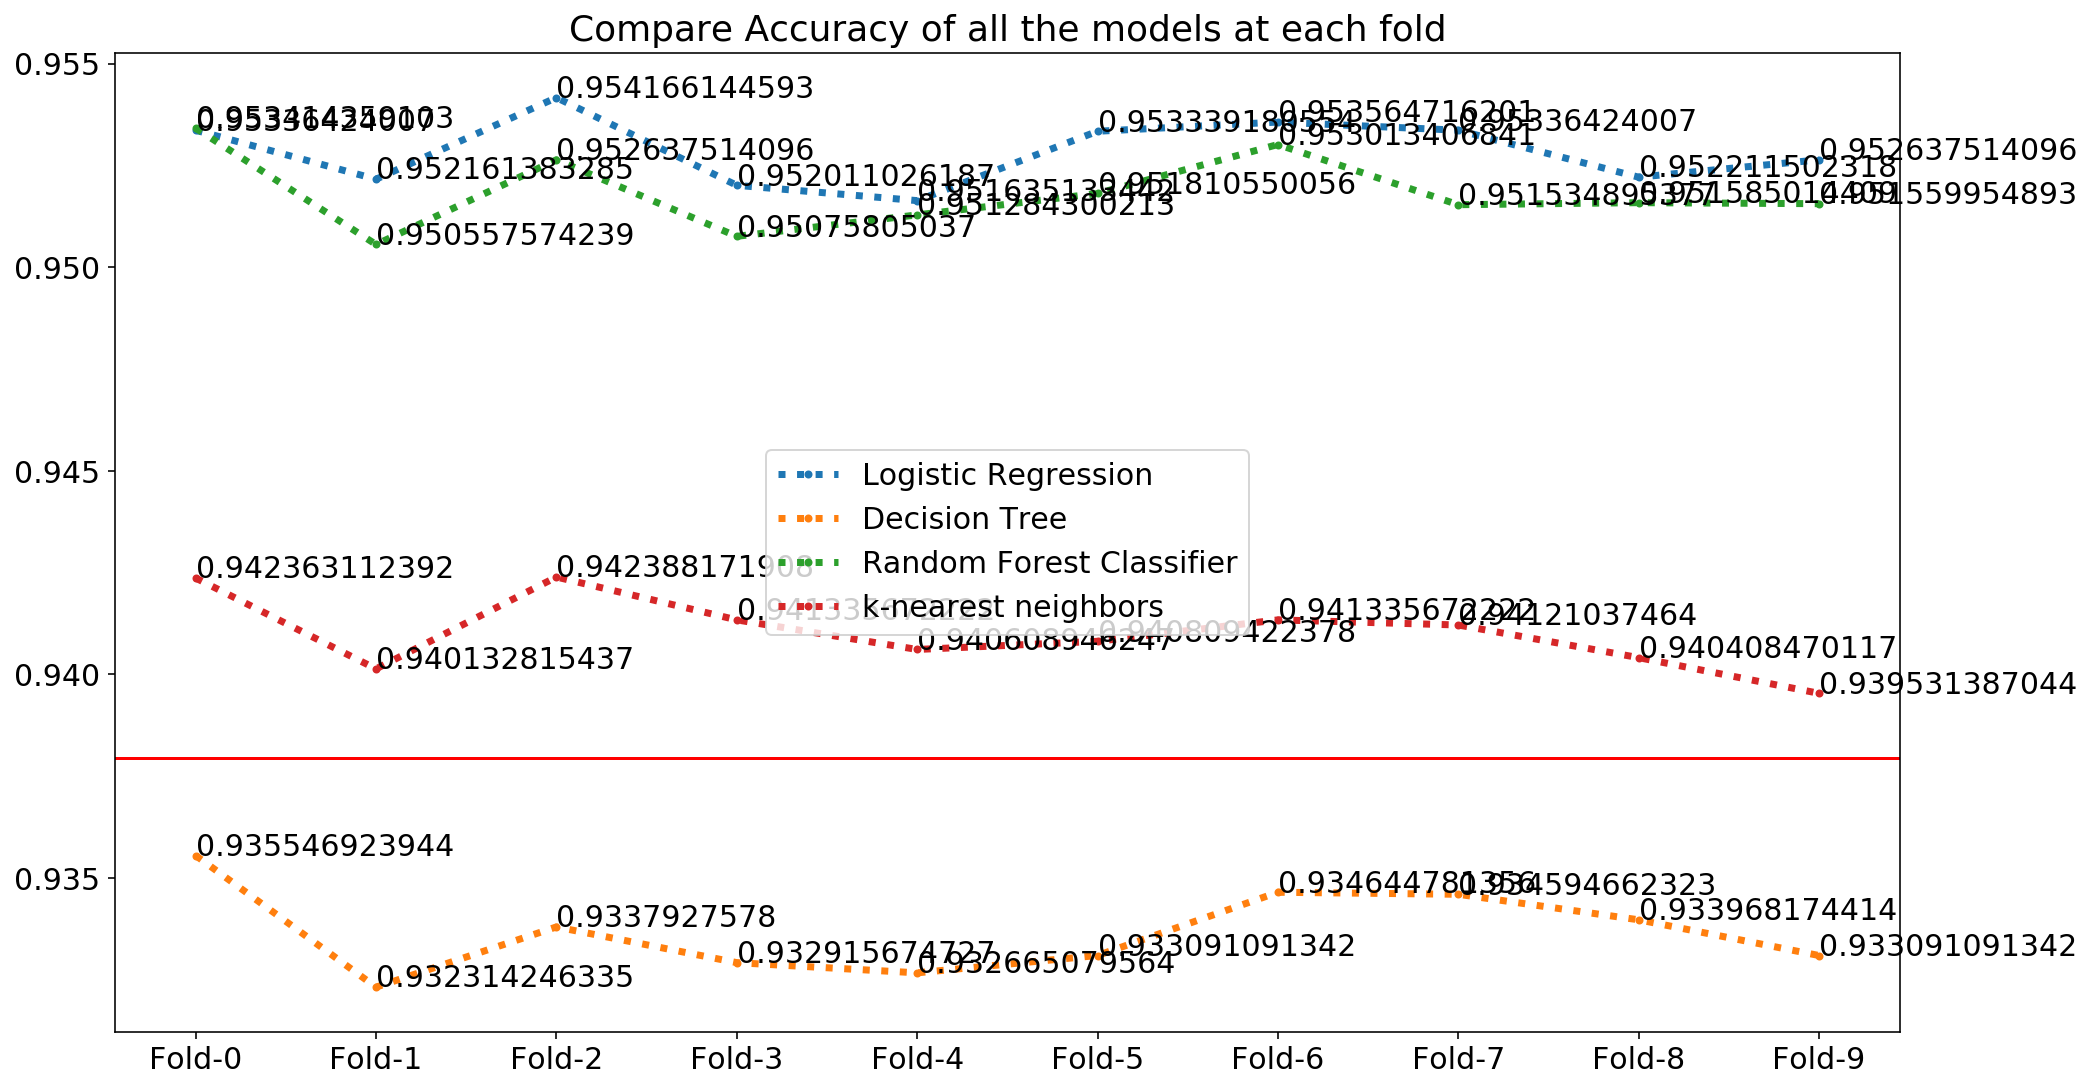

In [47]:
metric = "accuracy"
title = "Compare Accuracy of all the models at each fold"
plot_metric_each_fold(metric, title)

Out of all the models we used for classification all the accuracy score beats the baseline we set earlier, except of Decision Tree, whose accuracy is **93.3662%**, which is slightly less than what we expected from our model to perform. Apart from decision tree all the models seems to do a good job of classyfying the outcomes, which is great.

### Precision

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. Which means out of all Class 0, how many we predicted as Class 0. A high precision relates to the low false positive rate.<br/><br/>
$Precision= \dfrac{Total Number of Actual Positive classifications}{Total Number of Predicted Positive Classes} = \dfrac{TP}{TP + FP}$


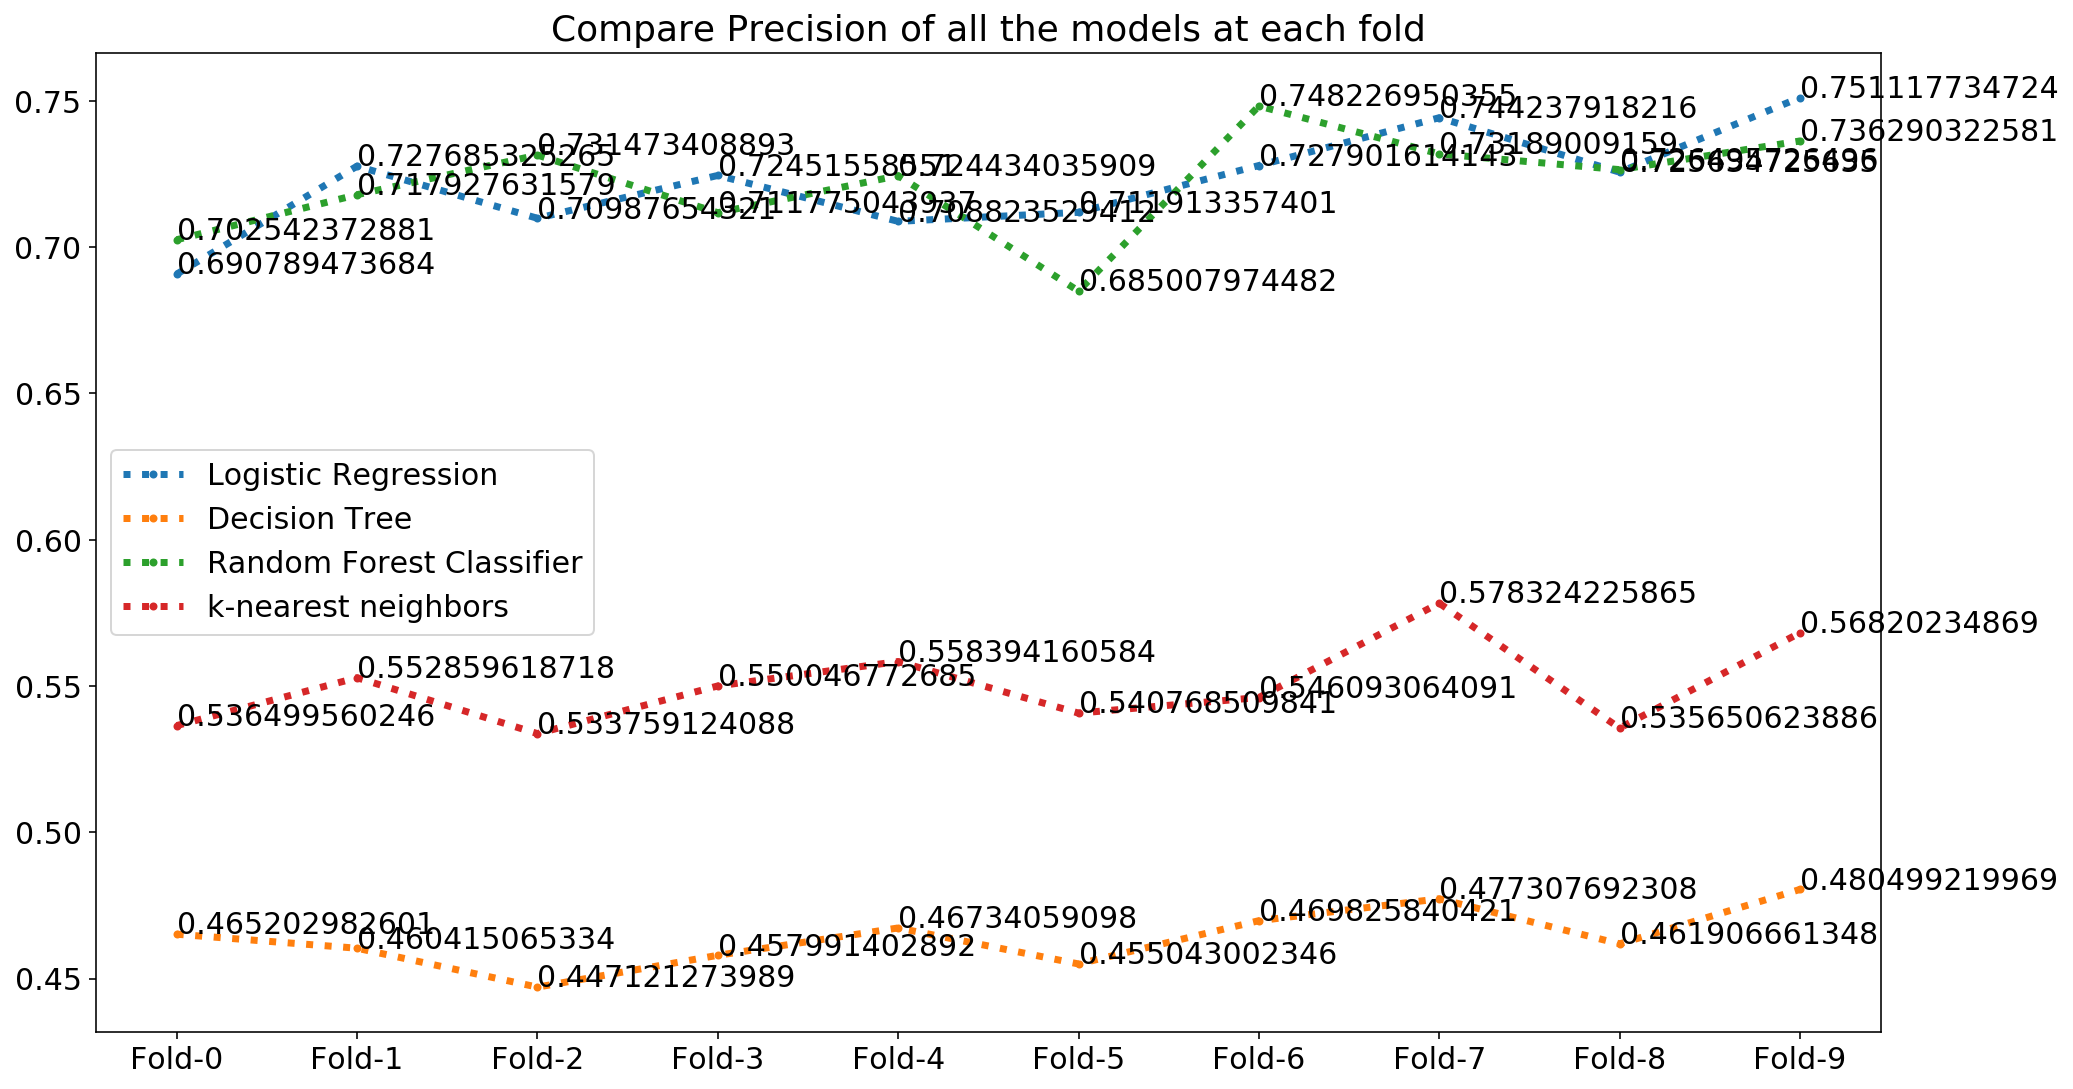

In [48]:
metric = "precision"
title = "Compare Precision of all the models at each fold"
plot_metric_each_fold(metric, title)

If our precision score is **0.61454525** (which is our average precision score for all the models) this says that if our classifier predicts someone to have an income below 50K is right about **61.45%** of the time. This is not bad because the number of population with income more than 50k are fewer than that of less than 50K.

### Recall

Recall(Sensitivity) is the ratio of correctly predicted positive observations to the all observations in actual class.<br/><br/>

$Recall= \dfrac{Total Number of Actual Positive classifications}{Total Number of actual Positive Classes} = \dfrac{TP}{TP + FN}$


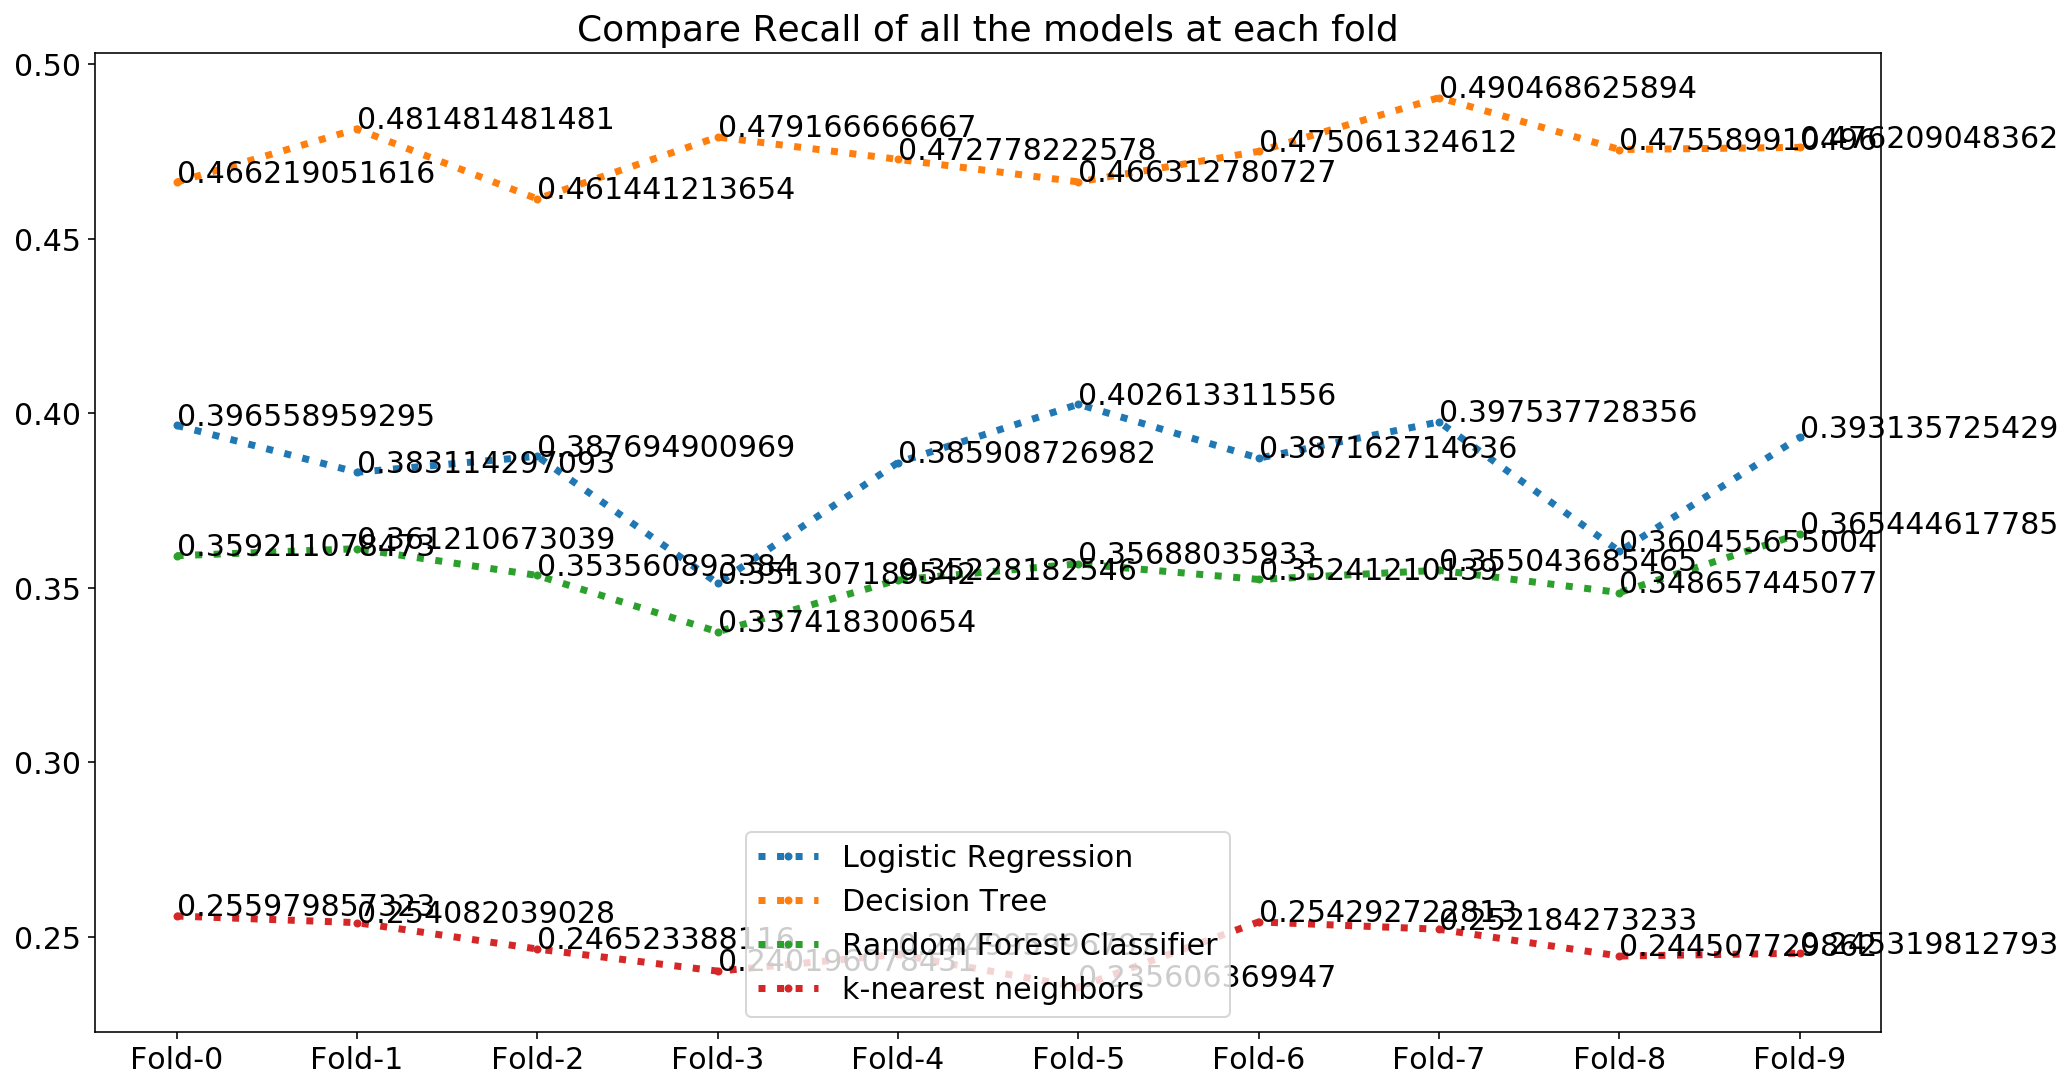

In [49]:
metric = "recall"
title = "Compare Recall of all the models at each fold"
plot_metric_each_fold(metric, title)

How many positives do I retrieve and how many do I miss. That is recall. So if the recall score is **0.36515075** (wchich is our average recall score for all the models), it means that the classifier predicts **36.51%** of the actual Class 0 correctly and looses **63.49%** of them.

---